**Junnan Shimizu**

Spring 2023

CS 252: Mathematical Data Analysis and Visualization

Project 7: Radial Basis Function Neural Networks

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Task 1: RBF Network development dataset

The eventual goal is to train a neural network so that it learns to recognize which human handwritten digit is shown in an image  (i.e. the numbers 0, 1, ..., 9). Before doing this, you will use simpler data to develop and debug your network.

### 1a. Load and preprocess data

- Load in the `rbf_dev_train.csv` and `rbf_dev_test.csv` train and test sets.
- For the train and test sets, separate the data variables (`X` and `Y`) from the class values (*class*). The test code below assumes the following names:
    - `y_train` and `y_test` for the class values in the train and test sets, respectively.
    - `rbf_dev_train` and `rbf_dev_test` for the train and test set data, respectively.
- Normalize each data feature "separately" between 0 and 1 (based on each feature's dynamic range).
    - Use the `min` and `max` values derived from the training set to normalize the test set. *This will ensure that identical feature values in the training and test sets get normalized to the same numeric value.*

**Tip:** It might be a good idea to write a few functions below so that you don't have a lot of duplicate code when processing train and test sets.

In [2]:
rbf_dev_train = pd.read_csv('data/rbf_dev_train.csv')
rbf_dev_test = pd.read_csv('data/rbf_dev_test.csv')

y_train = rbf_dev_train.iloc[:, 2]
rbf_dev_train = rbf_dev_train.iloc[:, :2]

y_test = rbf_dev_test.iloc[:, 2]
rbf_dev_test = rbf_dev_test.iloc[:, :2]

y_train = np.array(y_train)
rbf_dev_train = np.array(rbf_dev_train)
y_test = np.array(y_test)
rbf_dev_test = np.array(rbf_dev_test)

train_maxs = rbf_dev_train.max(axis=0)
train_mins = rbf_dev_train.min(axis=0)
# normalized train set
rbf_dev_train = (rbf_dev_train - train_mins) / (train_maxs - train_mins)

# normalized test set
rbf_dev_test = (rbf_dev_test - train_mins) / (train_maxs - train_mins)

#### Preprocessing test code

The following test code is a good sanity check, but you are encouoraged to do additional testing to make sure that your preprocessing pipeline is working properly.

##### Check dtypes

In [3]:
print(f'Your training set is an ndarray? {isinstance(rbf_dev_train, np.ndarray)}')
print(f'Your training classes is an ndarray? {isinstance(y_train, np.ndarray)}')
print(f'Your test set is an ndarray? {isinstance(rbf_dev_test, np.ndarray)}')
print(f'Your test classes is an ndarray? {isinstance(y_test, np.ndarray)}')

Your training set is an ndarray? True
Your training classes is an ndarray? True
Your test set is an ndarray? True
Your test classes is an ndarray? True


##### Check shapes

In [4]:
print(f'Your training set shape is {rbf_dev_train.shape} and should be (1600, 2).')
print(f'Your training classes shape is {y_train.shape} and should be (1600,).')
print(f'Your test set shape is {rbf_dev_test.shape} and should be (400, 2).')
print(f'Your test classes shape is {y_test.shape} and should be (400,).')

Your training set shape is (1600, 2) and should be (1600, 2).
Your training classes shape is (1600,) and should be (1600,).
Your test set shape is (400, 2) and should be (400, 2).
Your test classes shape is (400,) and should be (400,).


### 1b. Plot data

Create a scatter plot of the training data in the cell below.

- Color code each sample by its output class.
- Make the aspect ratio (height and width) of the x and y axes in the figure equal, otherwise the plot may look distorted.

If everything is working properly, you should see a jack-o-lantern whose eyes, noise, mouth, and stem are colored differently than the rest of the face.

(-0.05, 1.05, -0.05, 1.05)

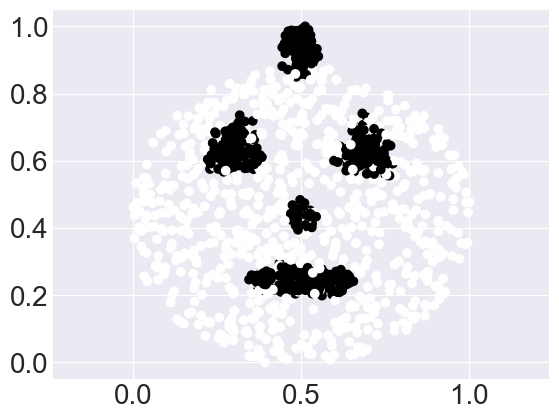

In [5]:
plt.scatter(rbf_dev_train[:, 0], rbf_dev_train[:, 1], c=y_train)
plt.axis('equal')

## Task 2: Radial basis function neural network

In [6]:
from rbf_net import RBF_Net

### 2a. Network initalization

You will use K-means to initialize the RBF hidden layer prototypes and sigmas.

1. Copy over your `kmeans.py` from your previous project. If your K-means clustering code isn't working properly, you may use `scipy` functions in this project instead, but at a 1 point reduction. Check out `scipy.cluster.vq.kmeans`.

2. Implement the method templates in `rbf.py` that initialize the hidden layer of the neural network:
    - Finish writing the constructor
    - `get_num_hidden_units`
    - `get_num_output_units`
    - `avg_cluster_dist`: Compute the average distance between each cluster center found by K-means and all the points assigned to the same cluster.
    - `initialize`: Use K-means to set the Gaussian hidden unit centers (**prototypes**) and standard deviations (**sigmas**).


In [7]:
from kmeans import KMeans

#### Test `avg_cluster_dist`

In [8]:
np.random.seed(0)

# N = 10 samples, M = 5 features
test_data = np.random.normal(size=(10, 5))
# 4 hidden units / prototypes, each has 5 features
test_centroids = np.random.normal(size=(4, 5))
# Each sample assigned to one of 4 hidden unit prototypes
test_assignments = np.random.randint(low=0, high=4, size=(10,))
kmeansObj = KMeans()

test_net = RBF_Net(4, 3)
print(f'Number of hidden units in your net is {test_net.get_num_hidden_units()} and should be 4')
print(f'Number of output units in your net is {test_net.get_num_output_units()} and should be 3')
test_clust_mean_dists = test_net.avg_cluster_dist(test_data, test_centroids, test_assignments, kmeansObj)

print(f'Your avg within cluster distances are\n{test_clust_mean_dists} and should be\n[2.23811 3.94891 3.12267 3.4321]')

Number of hidden units in your net is 4 and should be 4
Number of output units in your net is 3 and should be 3
Your avg within cluster distances are
[2.23811 3.94891 3.12267 3.4321 ] and should be
[2.23811 3.94891 3.12267 3.4321]


#### Test `initialize`

In [9]:
np.random.seed(0)
test_net.initialize(test_data)

print(f'Your prototypes have shape {test_net.get_prototypes().shape} and the shape should be (4, 5).')
print(f'Your hidden unit sigmas have shape {test_net.sigmas.shape} and the shape should be (4,).')

Your prototypes have shape (3, 5) and the shape should be (4, 5).
Your hidden unit sigmas have shape (3,) and the shape should be (4,).


#### Test initialization methods

In the cell below, write test code for your RBF network initialization:
- Create a new RBF network with 7 hidden units and 2 output classes.
- Call the `initalize` method on it, passing in the training data.
- Create a class color-coded scatterplot of the training data with an equal axis aspect ratio, like above, now with the prototypes clearly marked with a different marker and/or color.

You should see fairly evenly distributed prototypes, with one in most, if not all, "pockets" of samples belonging to a single class.

(-0.05, 1.05, -0.05, 1.05)

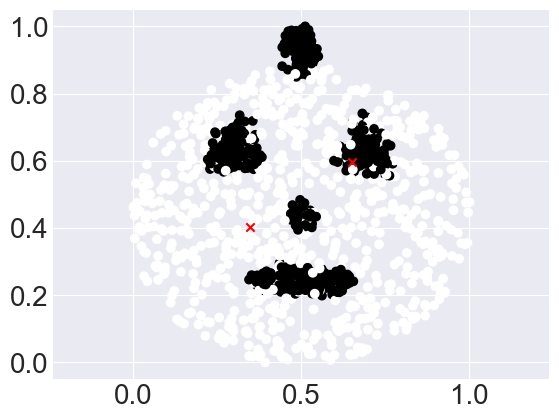

In [10]:
np.random.seed(0)

new_rbf = RBF_Net(7, 2)

new_rbf.initialize(rbf_dev_train)

plt.scatter(rbf_dev_train[:, 0], rbf_dev_train[:, 1], c=y_train)

prototypes = new_rbf.get_prototypes()
plt.scatter(prototypes[:, 0], prototypes[:, 1], c='red', marker='x')
plt.axis('equal')

**Question 1:** Do you think the prototypes enable the RBF network to learn the data well? Why or why not?

**Answer 1:** Yes I think they do enable the RBF network to learn the data well because the prototypes are similiar to the centroids we see in k-means where they allow us to see patterns in data by showing us where the clusters are in the data.

### 2b. Compute hidden and output layer activations

Implement the following methods so that you can train your RBF network:
- `hidden_act`: Computes hidden layer activation values: Determines the similarity between hidden layer prototypes with the input data.
- `output_act`: Computes output layer activation values: Multiply hidden unit activation by output unit weights.

**Hidden unit activation**:

The activation of hidden unit $j$ to data sample $i$ is computed according to $$H_{ij} = \exp \left (-\frac{\text{dist} \left (\vec{x}_i, \vec{c}_j \right )^2}{2\sigma_j^2 + \epsilon}\right )$$ 
where $\vec{x_i}$ is the data sample, $\vec{c_j}$ is the prototype (center) of the hidden unit, $\sigma_j$ is the hidden unit's standard deviation, $\epsilon$ is a small number (e.g. 1e-8), and $dist(\cdot, \cdot)^2$ is the **squared** Euclidean distance.

#### Test hidden_act

In [11]:
np.random.seed(1)

# N = 3 samples, M = 5 features
test_data = np.random.normal(size=(3, 5))
# 4 hidden units / prototypes, each has 5 features
test_centroids = np.random.normal(size=(4, 5))
# Each sample assigned to one of 4 hidden unit prototypes
test_sigmas = np.random.uniform(size=(4,))
test_wts = 2*np.random.uniform(size=(4+1, 3)) - 1

test_net = RBF_Net(4, 3)
test_net.prototypes = test_centroids
test_net.sigmas = test_sigmas
test_net.wts = test_wts
test_h_act = test_net.hidden_act(test_data)
print(f'Your hidden layer activation is\n{test_h_act}\n\nand should be')
print('[[0.      0.      0.00009 0.00033]\n [0.00013 0.      0.00004 0.00014]\n [0.      0.      0.      0.00001]]')

Your hidden layer activation is
[[0.      0.      0.00009 0.00033]
 [0.00013 0.      0.00004 0.00014]
 [0.      0.      0.      0.00001]]

and should be
[[0.      0.      0.00009 0.00033]
 [0.00013 0.      0.00004 0.00014]
 [0.      0.      0.      0.00001]]


#### Test output_act

In [12]:
test_out_act = test_net.output_act(test_h_act)
print(f'Your output layer activation is\n{test_out_act}\n\nand should be')
print('[[-0.72136  0.61505 -0.20481]\n [-0.72151  0.61487 -0.20466]\n [-0.72144  0.61479 -0.20465]]')

Your output layer activation is
[[-0.72136  0.61505 -0.20481]
 [-0.72151  0.61487 -0.20466]
 [-0.72144  0.61479 -0.20465]]

and should be
[[-0.72136  0.61505 -0.20481]
 [-0.72151  0.61487 -0.20466]
 [-0.72144  0.61479 -0.20465]]


### 2c. Learn network weights using linear regression

To train your RBF network, you will need to find optimal weights between hidden and output layer neurons to allows your network to accurately classify the training data (i.e. learn from the data). An efficient solution is to use linear regression to solve a least square problem: minimizing the squared difference between the *hidden layer activations* and the *true data classes*.

- **CS251:** In `rbf.py`, implement `linear_regression(A, y)`. To do this, adapt your code from the linear regression project involving `scipy.linalg.lstsq()` or `numpy.linalg.lstsq()`.
- **CS252:** In `rbf.py`, implement `linear_regression(A, y)`. To do this, adapt your code in `linear_regression` to use your QR solver.

#### Test linear regression

Running the following test code should generate a familar regression fit to the Iris data.

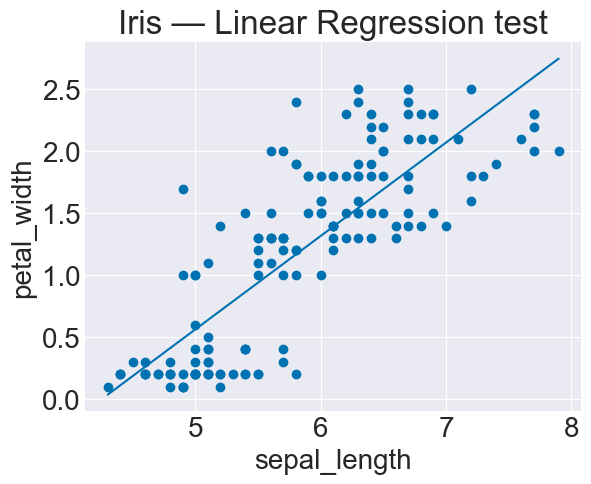

In [13]:
df = pd.read_csv('https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv')
iris = df[['sepal_length', 'petal_width']].to_numpy()

num_hidden_units = 1
num_classes = 4
net = RBF_Net(num_classes=num_classes, num_hidden_units=num_hidden_units)
iris_x = np.reshape(iris[:, 0], [len(iris), 1])
iris_y = np.reshape(iris[:, 1], [len(iris), 1])
iris_c = net.linear_regression(iris_x, iris_y)

line_x = np.linspace(iris_x.min(), iris_x.max())
line_y = line_x * iris_c[0] + iris_c[1]
plt.scatter(iris_x, iris_y)
plt.plot(line_x, line_y)
plt.title('Iris — Linear Regression test')
plt.xlabel('sepal_length')
plt.ylabel('petal_width')
plt.show()

### 2d. Train your RBF Network

Implement the following methods then train your neural network! In the cell below, train a RBF network with 10 hidden units on the RBF dev dataset. **If everything is working, you should get >=88% accuracy on the training set and >=89% on the test set.**

- `train`: Determine the optimal output layer weights that fit hidden layer activation using linear regression.
- `predict`: Use trained network (after learning) to predict the class of data.
- `accuracy`: Compute the accuracy by comparing the network predicted and actual class for each data sample.



In [14]:
rbf = RBF_Net(10, 30)
rbf.train(rbf_dev_train, y_train)
train_pred_y = rbf.predict(rbf_dev_train)
test_pred_y = rbf.predict(rbf_dev_test)

In [15]:
# Training set accuracy
print(rbf.accuracy(y_train, train_pred_y))

0.900625


In [16]:
# Test set accuracy
print(rbf.accuracy(y_test, test_pred_y))

0.9225


## Task 3: Handwritten digit classification: MNIST data

You will train a RBF network on a "real" image dataset of handwritten number digits:
- 60,000 images in training set, 10,000 images in test set.
- Each image is 28x28 pixels.
- The images are grayscale (no RGB colors).
- Each image (data sample) contains ONE of 10 numeric digit $0, 1, 2, \ldots, 8, 9$.

The goal is to train your network so that it can correctly predict the numeric digit in an image.

More information about MNIST: http://yann.lecun.com/exdb/mnist/

### 3a. Load in and look at MNIST dataset

- Use the numpy function `load` to load in the MNIST train/test data and the associated class labels.
- Create a 5x5 grid showing the first 25 images in the dataset. It should "look good" (e.g. turn off tick marks).

In [17]:
x_test = np.load('data/mnist_test_data.npy')
y_test = np.load('data/mnist_test_labels.npy')
x_train = np.load('data/mnist_train_data.npy')
y_train = np.load('data/mnist_train_labels.npy')

In [18]:
print(f'Your training set shape is {x_train.shape} and should be (60000, 28, 28).')
print(f'Your training classes shape is {y_train.shape} and should be (60000,).')
print(f'Your test set shape is {x_test.shape} and should be (10000, 28, 28).')
print(f'Your test classes shape is {y_test.shape} and should be (10000,).')

Your training set shape is (60000, 28, 28) and should be (60000, 28, 28).
Your training classes shape is (60000,) and should be (60000,).
Your test set shape is (10000, 28, 28) and should be (10000, 28, 28).
Your test classes shape is (10000,) and should be (10000,).


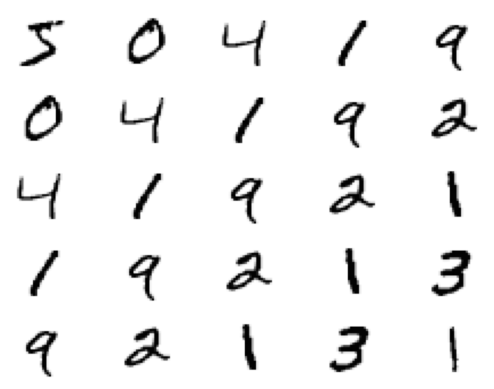

In [19]:
fig, axs = plt.subplots(5, 5)

for x in range(5):
    for y in range(5):
        axs[x, y].imshow(x_train[x + y])
        axs[x, y].axis('off')

### 3b. Preprocess data

- Flatten non-leading dimensions of the train and test sets. For example, the training set should go from (60000, 28, 28) to (60000, 784). **Do not hard code this!** Your code should work for any data with three dimensions.
- Normalize so that the maximum possible value in each image is 1 (and the minimum possible is 0) by dividing by 255.

In [20]:
def flatten(data):
     # data: ndarray. shape=3-dimensional. Flatten non-leading dimensions
        
    return np.reshape(data, newshape=(np.shape(data)[0], np.shape(data)[1]*np.shape(data)[2]))

flat_x_test = flatten(x_test)
flat_x_train = flatten(x_train)

#normalized
flat_x_test = flat_x_test / 255
flat_x_train = flat_x_train / 255

### 3c. Train and assess performance on MNIST

Train a RBF network on MNIST. **Your goal is to get >=90% accuracy on both train and test sets.**

**Tips:**
- Depending on your laptop or machine you are using, training could take many hours if you use the full 60,000 sample training set. Select a subset to train on (e.g. ~1500) that takes a reasonable amount of time (e.g. minutes). You should be able to hit your accuracy goals without too much data, effort, or time.
- Do not pare down the test set (i.e. it should remain at 10,000 samples).
- Use the code below to visualize your hidden layer prototypes to help with debugging (assumes your network is called `mnist_net`). Your prototypes should look like images of certain digits, perhaps a little blurrier.

In [21]:
flat_x_train = flat_x_train[:500]
y_train = y_train[:500]

mnist_net = RBF_Net(10, 140)
mnist_net.train(flat_x_train, y_train)

train_pred_y = mnist_net.predict(flat_x_train)
test_pred_y = mnist_net.predict(flat_x_test)

In [22]:
# train acc
print(mnist_net.accuracy(y_train, train_pred_y))

0.906


In [23]:
# test acc
print(mnist_net.accuracy(y_test, test_pred_y))

0.7769


(140, 28, 28)


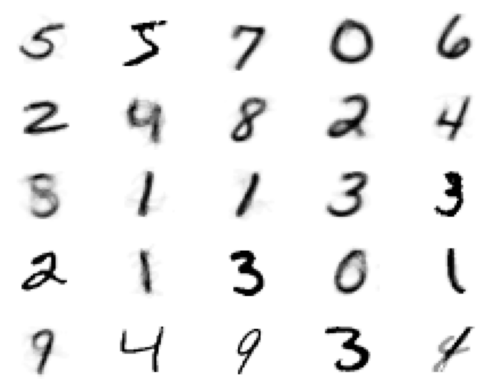

In [24]:
# Visualize network hidden layer prototypes
prototypes = mnist_net.get_prototypes()
prototypes = np.reshape(prototypes, [prototypes.shape[0], 28, 28])

print(prototypes.shape)

cols = rows = 5
fig, axes = plt.subplots(nrows=rows, ncols=cols)
for i in range(rows):
    for j in range(cols):
        axes[i, j].imshow(prototypes[i*rows + j])
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

**Question 2:** Which part of the training process takes the longest?

**Answer 2:** For my implementation, computing the activation of the hidden layer units likely takes the longest because I loop through every data sample and prototype combination (nested loop).

**Question 3:** What accuracy did you achieve on the training set? List all parameters that you needed to set (e.g. number of training samples, number hidden units, etc).

**Answer 3:** 92% accuracy. # of training samples = 500, # of hidden units = 20, # of classes = 140

**Question 4:** Using the same parameters to get the training accuracy that you reported in Question 3, what test accuracy did you achieve?

**Answer 4:** Unfortunately with these same parameters, it got 76.7% accuracy with the test set.

### 3d. Visualize prototypes using network weights

Now that you've trained the network to recognize handwritten digits, let's visualize the dominant factors that the network learns to rely on to make each prediction.

Create a 10 x 5 plot showing images of the 5 "most influential hidden layer prototypes" that contribute to predicting each of the 10 output classes. These are defined as the hidden layer prototypes that have the 5 largest weights going from the hidden layer to the output layer. *Recall that each hidden unit prototype has the same shape as a single data sample so each image in your grid should be 28x28.*

IndexError: index 10 is out of bounds for axis 1 with size 10

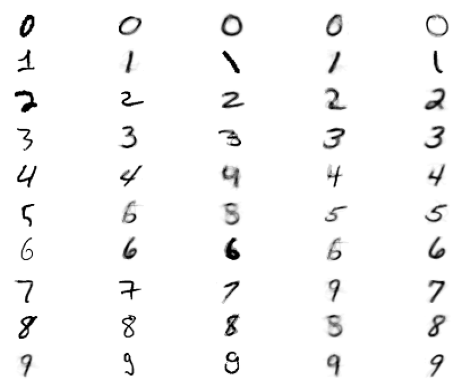

In [25]:
weights = mnist_net.wts[:-1]

fig, axes = plt.subplots(10, 5)

for i in range(mnist_net.num_classes):
    class_weights = weights[:, i]
    influential_prototypes = np.argsort(class_weights)[-5:]

    for j, proto_idx in enumerate(influential_prototypes):
        prototype = np.reshape(mnist_net.prototypes[proto_idx], (28, 28))
        axes[i, j].imshow(prototype)
        axes[i, j].axis('off')

plt.show()

**Question 5:** Interpret what each row of your 10x5 grid of images means. Did any of the top prototypes surprise you?

**Answer 5:** Each row represents the most influential hidden layer prototypes for determining the class. On the grid, image (0, 0), (0, 1), (3, 2), and (8, 2) were suprising to me because they are very blurry and slightly difficult to tell what the number is but still is one of the most influential hidden layer prototypes.

## Task 4: RBF neural networks for regression

In this task you will make modest changes and configure your RBF neural network to enable it to perform regression rather than solve classification problems.

### Task 4a. Plot regression curve data

Download and load in the regression "x values" (`'rbf_regression_x.npy'`) and "y values" (`'rbf_regression_y.npy'`). Create a plot of the curve that you on which will perform regression.

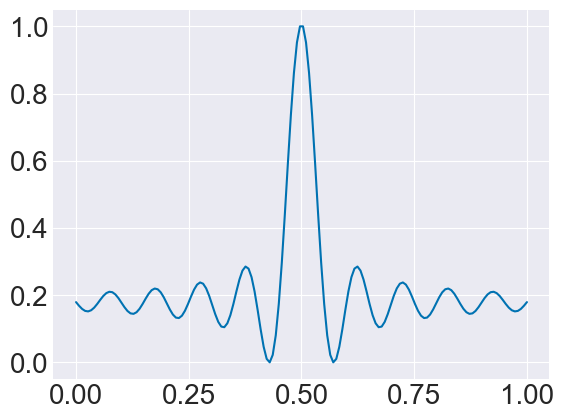

In [26]:
x_values = np.load('data/rbf_regression_x.npy')
y_values = np.load('data/rbf_regression_y.npy')

plt.plot(x_values, y_values)

### 4b. Implement a RBF Neural Network for Regression 

Implement the methods in the `RBF_Reg_Net` class. In every case except the constructor, this involves copy-pasting code from your classification network and making small changes.

Note that the hidden unit variance gain parameter ($g$) modifies the RBF function as follows:

$$H_{ij} = \exp \left (-\frac{\text{dist} \left (\vec{x}_i, \vec{c}_j \right )^2}{2g*\sigma_j^2 + \epsilon}\right )$$

#### Test: RBF regression neural network

- Create an object of the `RBF_Reg_Net` network. Configure it with:
    - 1 output neuron
    - 50 hidden units
    - the default value for the hidden unit variance gain.
- Train the network and have it predict y values at the training x values.
- Plot the original (x, y) values on the curve, and along with the predicted y values at the same x values.

**If everything is working, the regression performed by your network should produce an almost "perfect" reconstruction of the original data curve.**

In [27]:
from rbf_net import RBF_Reg_Net

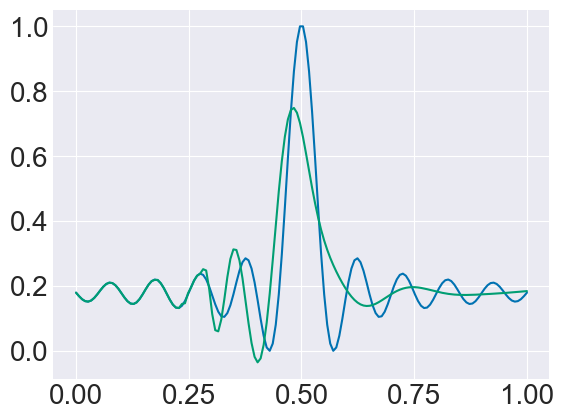

In [29]:
rbf_reg_net = RBF_Reg_Net(1, 50)
rbf_reg_net.train(x_values, y_values)
y_pred = rbf_reg_net.predict(x_values)

plt.plot(x_values, y_values)
plt.plot(x_values, y_pred)

# note: I get this error: 'array must not contain infs or NaNs' sometimes and I don't really know why, 
# but if run again, the error is avoided.

### 4c. Analysis of RBF Regression Neural Network

**Question 6:** Below, train the RBF regression network again, but with the hidden unit variance gain set to 1 .Superimpose the predicted regression curve with the original curve in the same plot. What happens and why?

**Answer 6:**  The data seems to compress more to the left as you can see with the major curve in the middle. This does make sense because we are reducing the h sigma gain which is a multiplicative gain factor applied to the hidden unit variances, so the data will be lowered. 

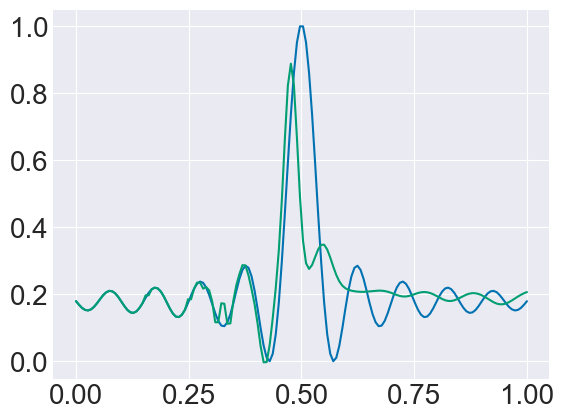

In [31]:
rbf_reg_net = RBF_Reg_Net(1, 50, 1)
rbf_reg_net.train(x_values, y_values)
y_pred = rbf_reg_net.predict(x_values)

plt.plot(x_values, y_values)
plt.plot(x_values, y_pred)

# note: I get this error: 'array must not contain infs or NaNs' sometimes and I don't really know why, 
# but if run again, the error is avoided.

**Question 7:** Run an experiment where you fix the hidden unit variance gain parameter to 5 and vary the number of hidden units in the network between 5 and 50. Create a plot showing the MSE of the predictions vs the original data for each networks with a different number of hidden units. Explain what the plot reveals about the number of hidden units in the network.

**Answer 7:** As you can see in the subplots below, as the number of hidden units in the netweork increases from 5 to 50, the MSE of the predictions gets closer and closer to the original data.

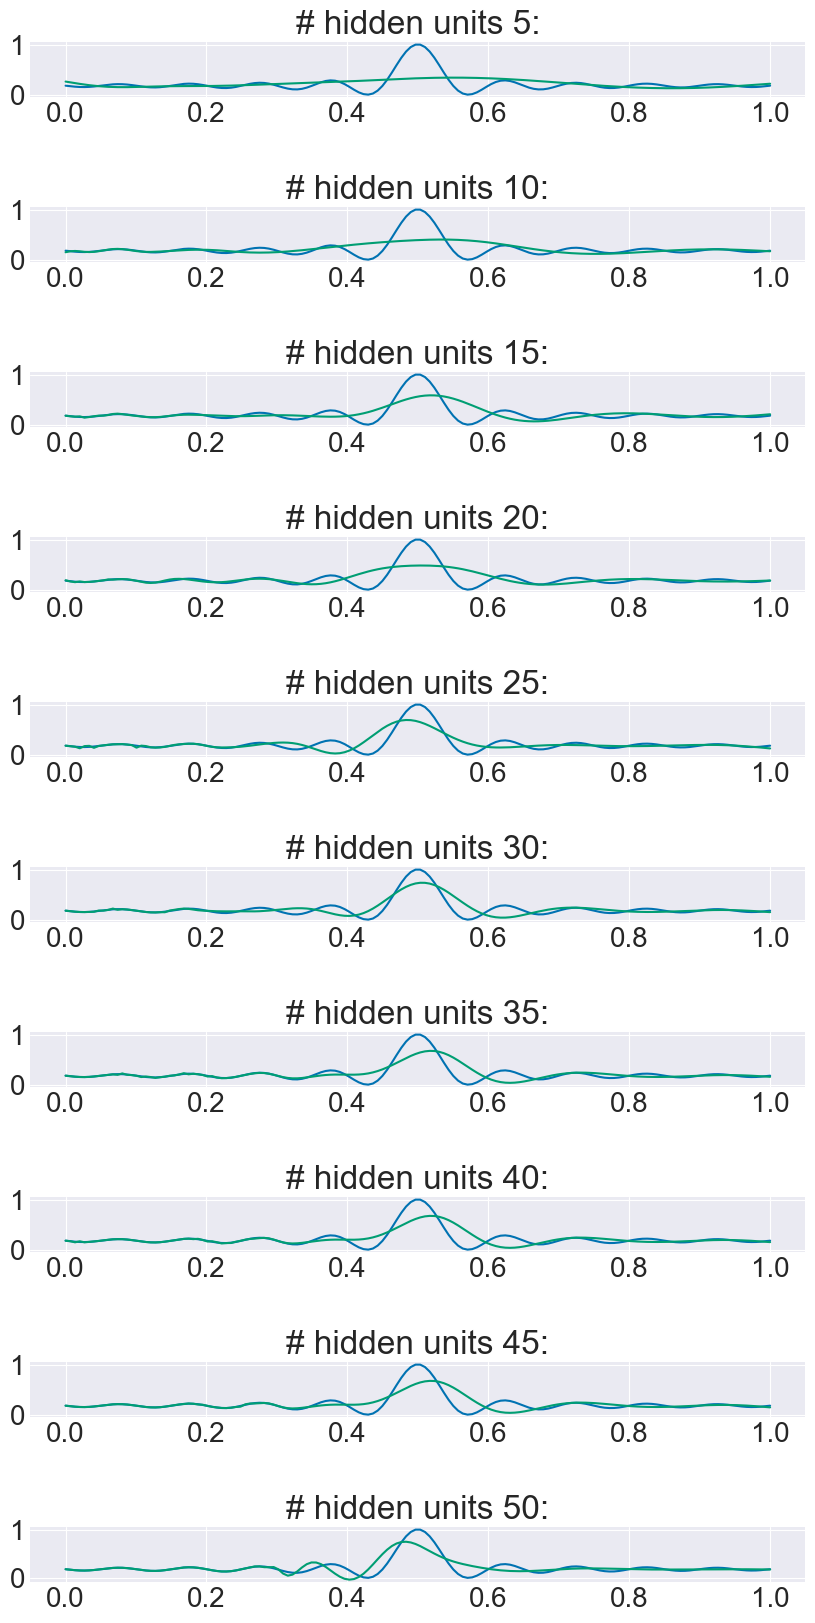

In [32]:
fig, axs = plt.subplots(10, 1, figsize=(10, 20))
plt.subplots_adjust(hspace=2)

for i in range(1, 11):
    rbf_reg_net = RBF_Reg_Net(1, 5*i, 5)
    rbf_reg_net.train(x_values, y_values)
    y_pred = rbf_reg_net.predict(x_values)

    axs[i - 1].plot(x_values, y_values)
    axs[i - 1].plot(x_values, y_pred)
    axs[i - 1].set_title("# hidden units {}:".format(i*5))

**Question 8:** Run an experiment where you fix the number of hidden units to 10 and vary the hidden unit variance gain parameter between 2 and 50. Create a plot showing the MSE of the predictions vs the original data for each networks with a different gain parameter value. Explain what the plot reveals about the hidden unit variance in the network.

**Answer 8:** The hidden unit variance helps the peak of the data be closer to the actual center of the data; however, this varies between each dataset, and a set value of the hidden unit variance does not always have the same effect on the data. In the case of this data, unit variance of about 26 centered the data well. 

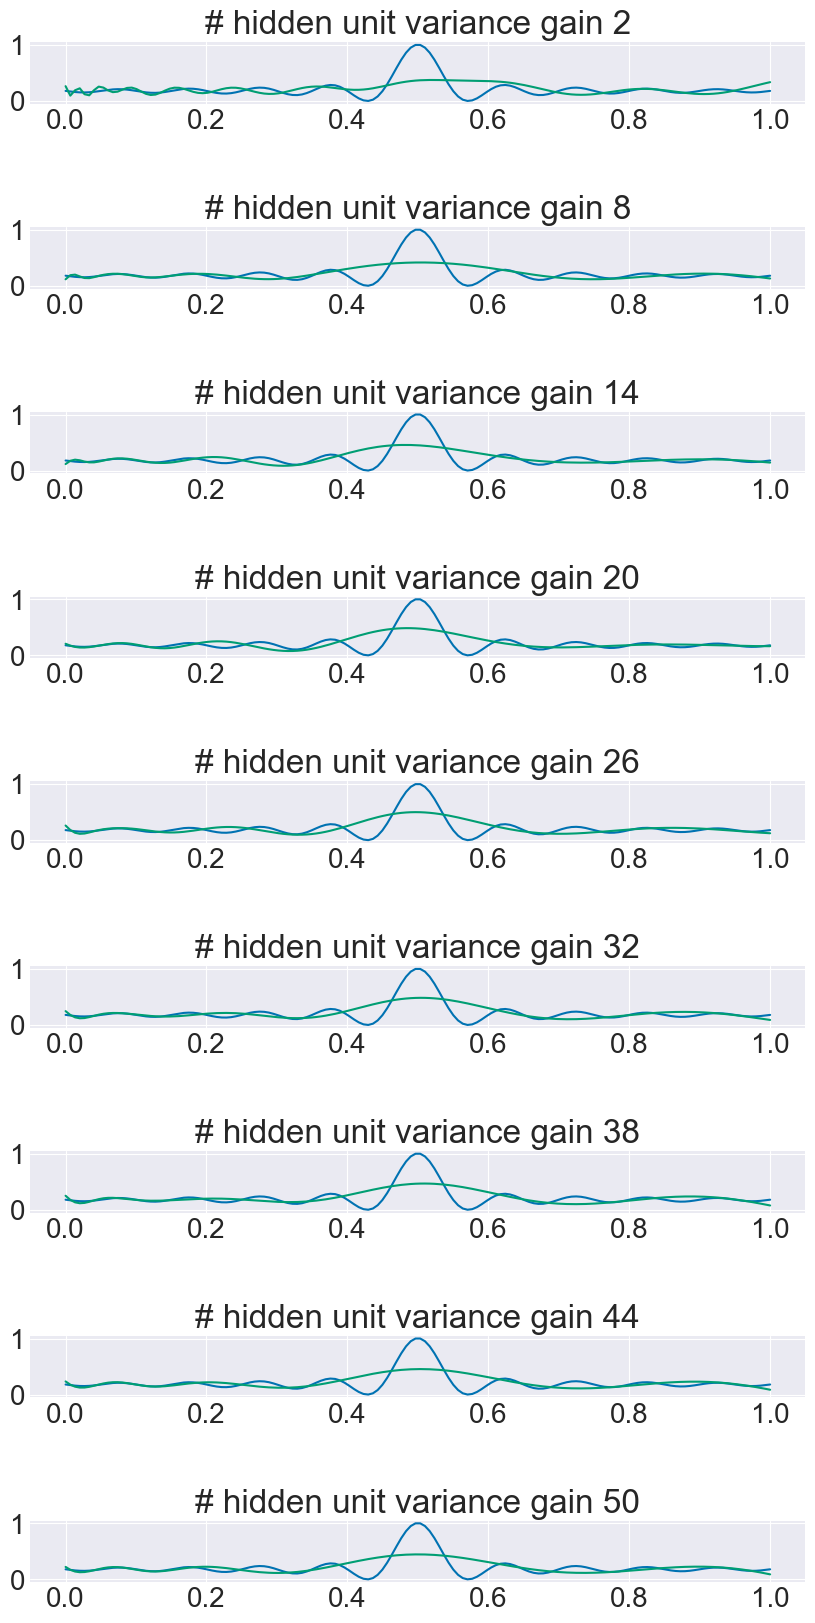

In [33]:
fig, axs = plt.subplots(9, 1, figsize=(10, 20))
plt.subplots_adjust(hspace=2)

for i in range(0, 9):
    rbf_reg_net = RBF_Reg_Net(1, 10, 2 + 6*i)
    rbf_reg_net.train(x_values, y_values)
    y_pred = rbf_reg_net.predict(x_values)

    axs[i].plot(x_values, y_values)
    axs[i].plot(x_values, y_pred)
    axs[i].set_title("# hidden unit variance gain {}".format(2 + 6*i))

## Extensions

To receive credit for any extension, you must:
- Not modify / prevent any code from the core project from working (e.g. make a copy before changing). In other words, **the notebook test code should still work!**
- **You must describe what you did and what you found in detail**. This includes a summary of parameter values used in your simulations.
- Include (*labeled!*) plots and/or numbers to present your results.
- Write up your extensions below or in a separate notebook.

**Rule of thumb: one deep, thorough extension is worth more than several quick, shallow extensions!**

### 1) Improve performance on MNIST with PCA

Using all 768 features (pixels) in each image may not be very helpful for classification. For example, pixels around the border are almost always white. Transform the dataset(s) using PCA to compress the number of features before training your RBF network. Experiment with PCA to improve classification accuracy and runtime performance.

### 2) Visualize network predictions

Make visualizations to show and interpret the MNIST network predictions. Lots of possibilities, here are a few specific ideas:
- Make show a grid of test samples labeled with their predicted digit.
- Analyze if the network performance favors accuracy for certain digits and not others.
- Are errors on certain classes correlated in any way? Does it depend on their digit similarity (e.g. 1 looks like a 7, but not a 0).
- Make and interpret a confusion plot.

### 3) Explore parameter space

When training your RBF network on MNIST, you had to pick some parameter values to use by hand. Pick one or more parameters and systematically vary them to quantify their effect on accuracy and simulation time.

### 4) Initialization schemes

Research, test out, and quantify the performance of different techniques to set the hidden unit prototypes and sigmas. For example, an alternative way to initialize the prototypes is to perform K-means to cluster each class *separately*. 

### 5) Other datasets

Use your RBF network to classify other datasets.

### 6) SVD-based linear regression

Implement a SVD-based linear regression method, which is both fast and numerically accurate. In the equation $Ac = y$ The weights $c$ can be solved via the following matrix equation: $$c = A^+y$$ where $A^+$ is the pseudo inverse of the matrix of RBF hidden layer activations $A$ (*data matrix*) and the correct classes $y$.

Relying on numpy to figure out the pseudoinverse would be a mini extension, computing the pseudoinverse yourself would be a larger extension.

### 7) Analyze the trained network

Run simulations then analyze and interpret the results. Here are some ideas:
- Visualize and analyze how the prototypes influence the classification results.
- Visualize and analyze how the network weights influence the classification results.

### 8) RBF networks for regression (CS252)

- Analyze the regression neural network's performance in scenarios when the training set is not equal to the training set.
- Explore and analyze how the RBF network could perform regression on a function with several inputs (e.g. $z = f(x, y)$). Test with real or simulated data.
- Explore and analyze how the RBF network could perform regression on a vector valued function with several outputs (e.g. $(y, z) = f(x)$). Test with real or simulated data.